Thais Lima de Sousa

# Efficient Graph-Based Image Segmentation
## Falzenszwalb e Huttenlocher's algorithm

In [21]:
from vpi.io import *
from vpi.filters import convolve, normalize
import numpy as np
import networkx as nx

In [22]:
# gaussian filter for image smoothing

def create_gauss_kernel(sigma):
    x = np.arange(- 4*sigma, 4*sigma + 1)
    k = np.zeros((1, x.size))
    length = int(np.ceil(8*sigma)) + 1
    for i in range(length):
        k[0][i] = np.exp(- x[i]**2 / 2*(sigma**2)) / (2*np.pi*(sigma**2))
    k = k / k.sum()

    return k

def smooth(img, sigma=0.8):
    kernel = create_gauss_kernel(sigma)  
    g = convolve(img, kernel)
    g = convolve(g, np.transpose(kernel))
    return g

In [51]:
# disjoint-set forest with union rank and path compression

class UF:

    def __init__(self, n):
        self.num = n
        self.parent = list(range(n))
        self.rank = [0 for i in range(n)]
        self.size = [1 for i in range(n)]
    
    def find(self, v):
        w = v
        while(w != self.parent[w]):
            w = self.parent[w]
        self.parent[v] = w
        return w
    
    def join(self, x, y):
        if self.rank[x] > self.rank[y]:
            self.parent[y] = x
            self.size[x] += self.size[y]
        
        else:
            self.parent[x] = y
            self.size[y] += self.size[x]
            if self.rank[x] == self.rank[y]:
                self.rank[y] += 1
        self.num -= 1
        
    def sizec(self, x):
        return self.size[x]
    
    def num_sets(self):
        return self.num

In [52]:
# graph segmentation

def threshold(size, c):
    return c/size

def segment_graph(G, k):
    V = len(G)
    E = G.size()
    c = 1.0*k
    u = UF(V)
    edges = list(G.edges_iter(data='weight'))
    edges.sort(key=lambda w:w[2])
    
    # init thresholdings
    L = [None]*V
    for i in range(V):
        L[i] = threshold(1.0, c)
      
    for i in range(V):
        pedge = edges[i]
        # components connected by this edge
        a = u.find(pedge[0])
        b = u.find(pedge[1])
        w = pedge[2]
        
        if not a == b:
            if w <= L[a] and w <= L[b]:
                u.join(a, b)
                a = u.find(a)
                L[a] = w + threshold(u.sizec(a), c)
                
    return u, edges

In [53]:
def diff(r, g, b, x1, y1, x2, y2):
    return np.sqrt(np.square(r[x1, y1] - r[x2, y2])
                  + np.square(g[x1, y1] - g[x2, y2])
                  + np.square(b[x1, y1] - b[x2, y2]))

def segment_image(im, sigma, k, min_size):
    H, W = im.shape[0:2]
    r = smooth(im[:,:,0], sigma)
    g = smooth(im[:,:,1], sigma)
    b = smooth(im[:,:,2], sigma)
    
    # build weighted edges, 8-connected
    G = nx.Graph()
    H, W = r.shape[0:2]
    
    for y in range(H):
        for x in range(W):            
            if x < W - 1: G.add_edge(y*W + x, y*W + (x+1), weight=diff(r, g, b, x, y, x+1, y))
            if y < H - 1: G.add_edge(y*W + x, (y+1)*W + x, weight=diff(r, g, b, x, y, x, y+1))
            if (x < W - 1 and y < H - 1): G.add_edge(y*W + x, (y+1)*W + (x+1), weight=diff(r, g, b, x, y, x+1, y+1))
            if (x < W - 1 and y > 0): G.add_edge(y*W + x, (y-1)*W + (x + 1), weight=diff(r, g, b, x, y, x+1, y-1))
    
    u, edge_list = segment_graph(G, k)
    
    # post process small components
    for e in edge_list:
        a = u.find(e[0])
        b = u.find(e[1])
        if (a != b and (u.sizec(a) < min_size) or u.sizec(b) < min_size):
            u.join(a, b)
        
    num_ccs = u.num_sets()

    # pick random colors for the components
    colors = np.random.rand(3*H*W).reshape(H*W, 3)
    output = im
    
    for y in range(H):
        for x in range(W):
            comp = u.find(y*W + x)
            output[x, y] = colors[comp]    
    
    return output, num_ccs   

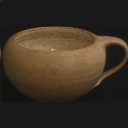

Found 252 components
(128, 128, 3) (128, 128, 3)


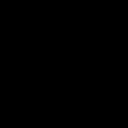

In [71]:
# read input

def main(img_name, sigma, k, min_size):
    img = read_image(img_name)
    display_image(img)
    # save output and display segmentation
    output, num_css = segment_image(img, sigma, k, min_size)
    print('Found %d components' % num_css)
    print(output.shape, img.shape)
    display_image(output)
        
main('img1.png', 0.5, 20, 10)